In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u

import pulsar

## Brightness time series

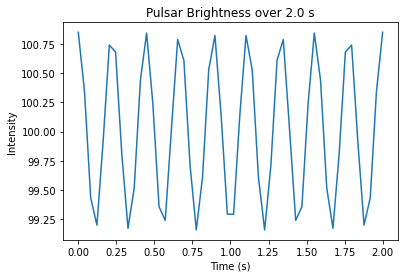

In [8]:
D = 0.1             # duty cycle number
phi0 = 1 * u.rad    # initial angle value
Ipeak = 100         # amplitude of intensity
period = 0.01 * u.s # rotational period (10 ms)

# Plotting a 2s time frame
time = 2 * u.s
tframe = np.linspace(0, time.value) * u.s

intensity = pulsar.intensity(Ipeak, phi0, D, period, tframe)

plt.plot(tframe, intensity)
plt.title(f'Pulsar Brightness over {time}')
plt.xlabel('Time (s)')
plt.ylabel('Intensity')
plt.show()

## Integrated Brightness

In [9]:
k = 0
#FIXME pulsar.integrated_intensity(Ipeak, phi0, D, period, tframe, k)